In [41]:
import heapq
import networkx as nx

import numpy as np
import scipy.sparse as sp

from typing import Optional

import matplotlib.pyplot as plt

from tqdm import tqdm

In [44]:
class PageRankSolution():
    def __init__(
            self, 
            dataset_file: Optional[str] = None
    ) -> None:
        self.dataset_file = dataset_file
        self.tm = None
        self.num_nodes = None

    @staticmethod
    def calculate_density_stats(
        transition_matrix
    ) -> None:
        if not sp.isspmatrix_csr(transition_matrix):
            transition_matrix = transition_matrix.tocsr()

        non_zero_count = transition_matrix.nnz

        row_indices, col_indices = transition_matrix.nonzero()

        row_degrees = np.bincount(row_indices, minlength=transition_matrix.shape[0])

        col_degrees = np.bincount(col_indices, minlength=transition_matrix.shape[1])

        min_row_degree = row_degrees.min()
        max_row_degree = row_degrees.max()
        avg_row_degree = row_degrees.mean()

        min_col_degree = col_degrees.min()
        max_col_degree = col_degrees.max()
        avg_col_degree = col_degrees.mean()

        print("General non-zero element statistics:")
        print(f"  Total number of non-zero elements: {non_zero_count}")

        print("Row degree statistics:")
        print(f"  Minimum row degree: {min_row_degree}")
        print(f"  Maximum row degree: {max_row_degree}")
        print(f"  Average row degree: {avg_row_degree:.4f}")

        print("Column degree statistics:")
        print(f"  Minimum column degree: {min_col_degree}")
        print(f"  Maximum column degree: {max_col_degree}")
        print(f"  Average column degree: {avg_col_degree:.4f}")


    def load_web_graph(
            self, 
            amount_of_nodes: int = 1000, 
            amount_of_edges: int = 5
    ):
        if not self.dataset_file:
            print("Web-graph dataset is not chosen, creating simulation")
            g = nx.powerlaw_cluster_graph(n=amount_of_nodes, m=amount_of_edges, p=0.1)
            
        else:
            print("Using real web-graph")
            g = nx.read_edgelist(self.dataset_file, create_using=nx.DiGraph)

        am = nx.adjacency_matrix(g)
        row_sums = np.array(am.sum(axis=1)).flatten()
        row_sums[row_sums == 0] = 1


        self.num_nodes = g.number_of_nodes()
        self.tm = sp.csc_matrix(am / row_sums[:, np.newaxis])

        return self.tm, self.num_nodes


    def create_A(
        self, 
        P: Optional[sp.csr_matrix] = None,
        num_nodes: Optional[int] = None
    ):
        if self.tm is None:
            self.tm = P
            self.num_nodes = num_nodes

        self.A = sp.eye(self.num_nodes, format='csc') - self.tm.T
        self.A_T = self.A.transpose().tocsc()

        return self.A


    def forward_grad(
            self, 
            gamma,
            x,
            h_k,
            i_plus,
            i_minus
    ):  
        import time
        
        h_k_sparse = sp.csr_array(h_k).reshape(-1, 1)

        Ah = self.A @ h_k_sparse
        ATAh = self.A_T @ Ah
        
        ATAh = ATAh.toarray().reshape(-1)

        max_term = np.zeros_like(x)
        max_term[i_plus] = np.maximum(-x[i_plus] + h_k[i_plus], 0) - np.maximum(-x[i_plus], 0)
        max_term[i_minus] = np.maximum(-x[i_minus] + h_k[i_minus], 0) - np.maximum(-x[i_minus], 0)
        
        return ATAh + gamma * max_term


    def calculate_h(
            self,
            L1: float,
            grad: list,
            i_plus: int,
            i_minus: int
    ) -> list:
        grad_diff = grad[i_plus] - grad[i_minus]

        h_k = np.zeros(self.num_nodes)
        h_k[i_plus] = -grad_diff / (4 * L1)
        h_k[i_minus] = grad_diff / (4 * L1)
        
        return h_k


    def nl1(
            self, 
            gamma=0.01, 
            max_iter=10000
    ) -> tuple[list, list]:
        if self.A is None:
            raise ValueError("I - P^T not loaded. Call create_A() first.")
        
        loss = []
        L1 = 1 + gamma

        x = np.zeros(self.num_nodes)
        x[0] = 1

        Ax = self.A @ x
        grad = self.A.T @ Ax + gamma * np.maximum(-x, 0)


        with tqdm(total=max_iter, desc="Optimizing NL1") as pbar:
            for _ in range(max_iter):
                i_plus = np.argmax(grad)   
                i_minus = np.argmin(grad)

                h_k = self.calculate_h(L1=L1, grad=grad, i_plus=i_plus, i_minus=i_minus)
                
                x += h_k

                grad += self.forward_grad(gamma=gamma, x=x, h_k=h_k, i_plus=i_plus, i_minus=i_minus)

                loss.append(np.linalg.norm(self.A @ x))

                pbar.set_postfix({'loss': 1, 'i_minus': i_minus, 'i_plus': i_plus})
                pbar.update(1)
        
        return x, loss

In [45]:
prk = PageRankSolution(dataset_file="web-Stanford.txt")
P, num_nodes = prk.load_web_graph()
A = prk.create_A()

Using real web-graph


In [46]:
x, loss = prk.nl1(max_iter=100000, gamma=1)

Optimizing NL1:   0%|          | 0/100000 [00:00<?, ?it/s]

Optimizing NL1: 100%|██████████| 100000/100000 [26:52<00:00, 62.03it/s, loss=1, i_minus=205630, i_plus=93580]


0.0008866953377029343
1.0000000000000013


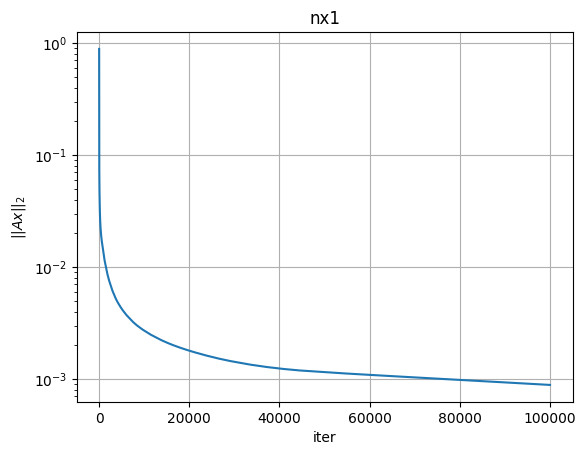

In [52]:
plt.plot(loss)
plt.yscale('log')
plt.title("nx1")
plt.ylabel("$||Ax||_{2}$")
plt.xlabel("iter")
plt.grid()
print(loss[-1])
print(np.sum(x))

In [53]:
n = P.shape[0]
I = np.ones(n) / n
max_iterations = 100000

errors_real = []
with tqdm(total=max_iterations, desc="Optimizing NL1") as pbar:
    for _ in range(max_iterations):
        I_old = I.copy()
        I = P.T @ I
        error = np.linalg.norm(I - I_old) 
        errors_real.append(error)
        pbar.set_postfix({'error': 1})
        pbar.update(1)



Optimizing NL1: 100%|██████████| 100000/100000 [26:12<00:00, 63.61it/s, error=1]


0.0009481771224720081


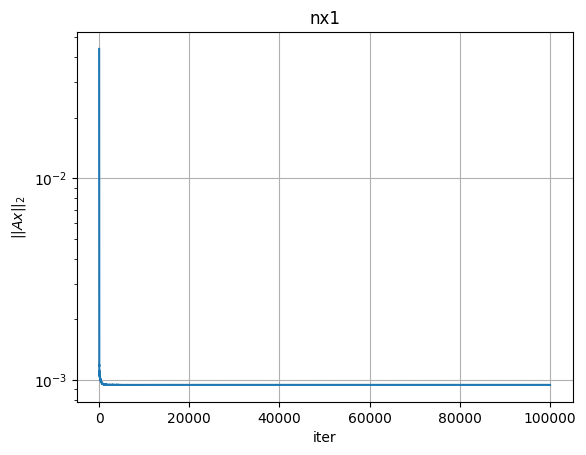

In [55]:
plt.plot(errors_real)
plt.yscale('log')
plt.title("nx1")
plt.ylabel("$||Ax||_{2}$")
plt.xlabel("iter")
plt.grid()
print(errors_real[-1])